### シグモイド関数

基本形はこんな数式らしい。

$　 f_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}　$

グラフにしてみるかね

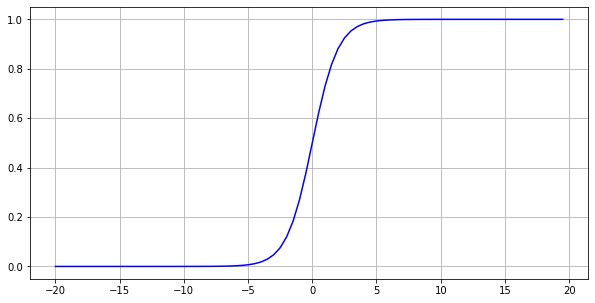

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

def sigmoid(x):
    """シグモイド関数"""
    e = math.e
    return 1/(1 + e**-x)

x = np.arange(-20, 20, 0.5)
y = sigmoid(x)

fig = plt.figure(figsize=(10.0, 5.0))

plt.plot(x, y, color='blue')

plt.grid()
plt.show()

まぁ要するに `0 - 1` の間、0 でちょうど `0.5` となってるので、パーセンテージを扱う処理に向いてるって話らしい。  
これで単純な二値判定するなら、`0.5` が当然のようにボーダーになるわけで…

### 長方形の縦長横長判定を考える

0 がちょうど 50% なので、それがプラスかマイナスかで 1/ 0 と判定すればいいので

$$
  y =
  \begin{cases}
     1 \quad (\theta^T \geq 0 0) \\
     0 \quad (\theta^T \leq 0) \\
  \end{cases}
$$

という形になる。

これで長方形判定しようとしてみる。  
仮に横長である確率を求めると考えて、横軸を $x_1$ 縦軸を $x_2$ として適当なパラメータを与えてみる（あくまでも適当）

$$
  \theta =\left[
    \begin{array}{rrr}
        \theta_0 \\
        \theta_1 \\
        \theta_2
    \end{array}
  \right] = \left[
    \begin{array}{rrr}
        -50 \\
        4 \\
        2
    \end{array}
  \right], \quad x = \left[
    \begin{array}{rrr}
        1 \\
        x_1 \\
        x_2
    \end{array}
  \right]
$$

式に直すと

$$
    \theta^Tx = -50 \cdot 1 + 4x_1 + 2x_2  \geq 0 \\
    2x_2 \geq 50 - 4x_1 \\
    x_2 \geq 25 - 2x_1
$$

図にすると

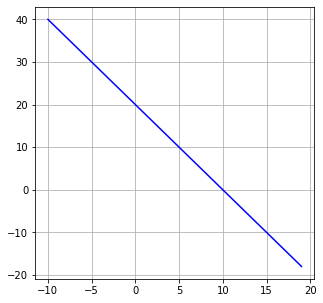

In [6]:
def func(x):
    return 20 - 2 * x

x = np.arange(-10, 20, 1)
y = func(x)

fig = plt.figure(figsize=(5.0, 5.0))

plt.plot(x, y, color='blue')

plt.grid()
plt.show()

$x_2$ つまり y が大きいときに 1 なのだから、上記グラフの右上に当たる場合は横長と判定するわけだ。  
ちなみに前回のデータもプロットすると

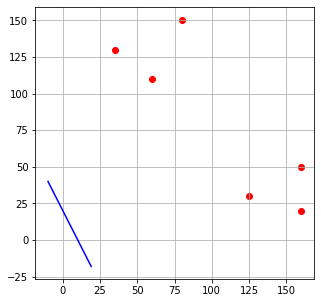

In [8]:
nx = np.array([80, 60, 35, 160, 160, 125])
ny = np.array([150, 110, 130, 50, 20, 30])

x = np.arange(-10, 20, 1)
y = func(x)

fig = plt.figure(figsize=(5.0, 5.0))

plt.plot(x, y, color='blue')
plt.scatter(nx, ny, color='red')

plt.grid()
plt.show()

デフォだと全部横長扱いだぜひゃっほう  
で、 $\theta$ を適当に決めたのが悪いので、これを求めるために、

1. 目的関数を作る
2. 微分して更新式を求める

て事すれば良さげ。

### 尤度

扱うのは確率なので、それを当てはめて考える。  
未知のデータ $x$ が横長である確率を $P(y=1|x) = f_\theta(x)$ として考える。

| 横幅 | 縦幅 | 形 | y | 確率 |
|------|------|----|---|---|
| 80 | 150 | 縦長 | 0 | $P(y=0|x)$ が最大が理想 |
| 60 | 110 | 縦長 | 0 | 同上 |
| 35 | 130 | 縦長 | 0 | 同上 |
| 160 | 50 | 横長 | 1 | $P(y=1|x)$ が最大が理想 |
| 160 | 20 | 横長 | 1 | 同上 |
| 125 | 30 | 横長 | 1 | 同上 |

この学習データは全部独立して発生すると考えると

$$
L(\theta)=P(y^{(1)}=0|x^{(1)})P(y^{(2)}=0|x^{(2)})P(y^{(3)}=0|x^{(3)})P(y^{(4)}=1|x^{(4)})P(y^{(5)}=1|x^{(5)})P(y^{(6)}=0|x^{(6)})\\
L(\theta)=\prod_{i=1}^{N}P(y^{(i)}=1|x^{(i)})^{y^{(i)}}P(y^{(i)}=0|x^{(i)})^{1-y^{(i)}}
$$

うおぉぉぉおおおお（TT

とまれ、$y^{(i)}$ が 0 か 1 にできるなら、２つの $P$ のうち片方だけ残るので、実質間違ってない…ナルホドって感じだが、言われなきゃ出てこねえ（TT

この $L(\theta)$ を尤度というそうな…えっぐ

### 対数尤度関数

今出た式は同時確率（複数の結果が同時に発生する確率）なので、値が死ぬほど小さくなる。  
なんで、対数を取る。

$logL(\theta)$

常用対数のグラフは

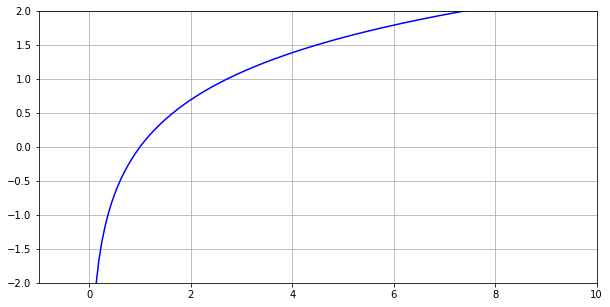

In [27]:
x = np.arange(0.0625, 10, 0.0625)  # 1/16 = 0.0625
y = np.log(x)

fig = plt.figure(figsize=(10.0, 5.0))

plt.xlim(-1, 10)
plt.ylim(-2, 2)

plt.plot(x, y, color='blue')

plt.grid()
plt.show()

これで式変形してくと最終的に

$logL(\theta)=\sum_{i=1}^{n}( y^{(i)}logf_{\theta}(x^{(i)}) + (1-y^{(i)})log(1-f_{\theta}(x^{(i)}) )$

これを微分すると

$\frac{\partial logL(\theta)}{\partial \theta_j} = \frac{\partial}{\partial \theta_j}\sum_{i=1}^{n}(x^{(i)}log f_{\theta}(x^{(i)}) + (1-y^{(i)})log(1 - f_{\theta}(x^{(i)})))$

